In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2024-05-02 10:55:03--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   133MB/s    in 1.4s    

2024-05-02 10:55:05 (133 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
!ls

drive  ml-20m  ml-20m.zip  sample_data


In [6]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [8]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [9]:
#Get user ids and movie ids and their ratings
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [24]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

In [25]:
#Set embedding dimension
D = 10

In [26]:
#Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden = 1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    #set the weights since N(0, 1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01)
    )
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01)
    )

  def forward(self, u, m):
    u = self.u_emb(u)
    m = self.m_emb(m)

    #merge
    out = torch.cat((u, m), 1)

    #ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [29]:
#Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [30]:
# A function to encapsualte the training loop
def  batch_gd(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  #batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      users = train_users[j * bs: (j+1) * bs]
      movies = train_movies[j * bs: (j+1) * bs]
      targets = train_ratings[j * bs: (j+1) * bs]

      #convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      targets = targets.view(-1, 1).float()
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    test_loss = []
    for j in range(int(np.ceil(len(test_users)/bs))):
      users = test_users[j * bs: (j+1) * bs]
      movies = test_movies[j * bs: (j+1) * bs]
      targets = test_ratings[j * bs: (j+1) * bs]

      #convert to Tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      targets = targets.view(-1, 1).float()
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    #Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss: .4f}, \
    Test Loss: {test_loss: .4f}, Duration: {dt}')
  return train_losses, test_losses

In [31]:
#shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [32]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

In [33]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10)

Epoch 1/10, Train Loss:  0.7373,     Test Loss:  0.6974, Duration: 0:01:01.062339
Epoch 2/10, Train Loss:  0.6688,     Test Loss:  0.6610, Duration: 0:01:02.647432
Epoch 3/10, Train Loss:  0.6356,     Test Loss:  0.6592, Duration: 0:01:00.825315
Epoch 4/10, Train Loss:  0.6147,     Test Loss:  0.6459, Duration: 0:01:03.827961
Epoch 5/10, Train Loss:  0.5975,     Test Loss:  0.6340, Duration: 0:01:00.092025
Epoch 6/10, Train Loss:  0.5843,     Test Loss:  0.6328, Duration: 0:01:02.271693
Epoch 7/10, Train Loss:  0.5747,     Test Loss:  0.6287, Duration: 0:01:00.234451
Epoch 8/10, Train Loss:  0.5675,     Test Loss:  0.6280, Duration: 0:01:03.856152
Epoch 9/10, Train Loss:  0.5619,     Test Loss:  0.6300, Duration: 0:01:00.250181
Epoch 10/10, Train Loss:  0.5572,     Test Loss:  0.6270, Duration: 0:01:01.805896


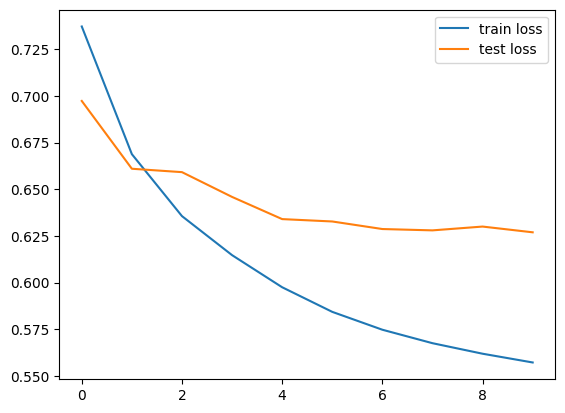

In [34]:
#Plot the train loss  and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()